In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import root_mean_squared_error, mean_squared_error

In [7]:
df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet')

df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)

In [8]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN


In [9]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

In [10]:
#df = df[df.trip_type == 2]

In [11]:
df.duration.describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

In [13]:
bf_count = len(df)
df = df[(df.duration >= 1) & (df.duration <= 60)]
af_count = len(df)
print(af_count, bf_count)
print(af_count/bf_count * 100)

3009173 3066766
98.1220282212598


In [14]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

In [15]:
df[categorical] = df[categorical].astype(str)
# object datatypes are str in pandas

/tmp/ipykernel_45050/2894774450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [16]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                     object
DOLocationID                     object
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
duration                        float64
dtype: object

In [17]:
train_dicts = df[categorical + numerical].to_dict(orient = "records")

In [18]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [19]:
X_train

<3009173x516 sparse matrix of type '<class 'numpy.float64'>'
	with 9027519 stored elements in Compressed Sparse Row format>

In [20]:
target= 'duration'
y_train = df[target].values

In [21]:
y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [23]:
y_pred = lr.predict(X_train)

In [24]:
print(y_pred)
print(y_train)

[11.47419655 10.94682493 11.36738586 ... 11.6683345  12.70006847
 11.60926734]
[ 8.43333333  6.31666667 12.75       ... 24.51666667 13.
 14.4       ]


/tmp/ipykernel_45050/1219225857.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label="prediction")
/tmp/ipykernel_45050/1219225857.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label="actual")


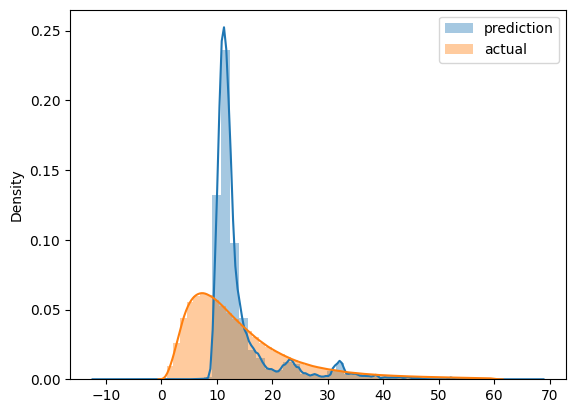

In [25]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_train, label="actual")

plt.legend()

In [26]:
root_mean_squared_error(y_train, y_pred)
#mean_squared_error(y_train, y_pred, squared=False)

7.658396898909143

In [17]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    
    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)
    print(df.duration.describe())
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID','DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [18]:
df_train = read_dataframe("./data/yellow_tripdata_2023-01.parquet")
df_val = read_dataframe("./data/yellow_tripdata_2023-02.parquet")

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64
count    2.913955e+06
mean     1.601591e+01
std      4.284210e+01
min     -4.361667e+01
25%      7.250000e+00
50%      1.180000e+01
75%      1.876667e+01
max      7.053617e+03
Name: duration, dtype: float64


In [15]:
len(df_train), len(df_val)

(3009173, 2855951)

In [16]:
df_train.duration.descrip

count    3.009173e+06
mean     1.420486e+01
std      9.939386e+00
min      1.000000e+00
25%      7.216667e+00
50%      1.155000e+01
75%      1.818333e+01
max      6.000000e+01
Name: duration, dtype: float64

In [ ]:
df_train["PU_DO"] = df_train["PULocationID"] + '_' + df_train["PULocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + '_' + df_val["PULocationID"]

In [11]:
df_val

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,duration,PU_DO
0,1,2023-02-01 00:32:53,2023-02-01 00:34:34,2.0,0.30,1.0,N,142,163,2,...,3.50,0.5,0.00,0.0,1.0,9.40,2.5,0.00,1.683333,142_142
3,1,2023-02-01 00:29:33,2023-02-01 01:01:38,0.0,18.80,1.0,N,132,26,1,...,2.25,0.5,0.00,0.0,1.0,74.65,0.0,1.25,32.083333,132_132
4,2,2023-02-01 00:12:28,2023-02-01 00:25:46,1.0,3.22,1.0,N,161,145,1,...,1.00,0.5,3.30,0.0,1.0,25.30,2.5,0.00,13.300000,161_161
5,1,2023-02-01 00:52:40,2023-02-01 01:07:18,1.0,5.10,1.0,N,148,236,1,...,3.50,0.5,5.35,0.0,1.0,32.25,2.5,0.00,14.633333,148_148
6,1,2023-02-01 00:12:39,2023-02-01 00:40:36,1.0,8.90,1.0,N,137,244,1,...,3.50,0.5,3.50,0.0,1.0,50.00,2.5,0.00,27.950000,137_137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2913950,2,2023-02-28 23:46:00,2023-03-01 00:05:00,NaN,4.65,NaN,None,249,140,0,...,0.00,0.5,4.84,0.0,1.0,29.06,NaN,NaN,19.000000,249_249
2913951,2,2023-02-28 23:26:02,2023-02-28 23:37:10,NaN,2.47,NaN,None,186,79,0,...,0.00,0.5,2.65,0.0,1.0,20.31,NaN,NaN,11.133333,186_186
2913952,2,2023-02-28 23:24:00,2023-02-28 23:38:00,NaN,3.49,NaN,None,158,143,0,...,0.00,0.5,0.00,0.0,1.0,21.64,NaN,NaN,14.000000,158_158
2913953,2,2023-02-28 23:03:00,2023-02-28 23:10:00,NaN,2.13,NaN,None,79,162,0,...,0.00,0.5,2.63,0.0,1.0,20.19,NaN,NaN,7.000000,79_79


In [15]:
categorical = ['PULocationID','DOLocationID'] #["PU_DO"]
#numerical = ['trip_distance']

dv = DictVectorizer()

# train_dicts = df_train[categorical + numerical].to_dict(orient = "records")
train_dicts = df_train[categorical].to_dict(orient = "records")
X_train = dv.fit_transform(train_dicts)

# val_dicts = df_val[categorical + numerical].to_dict(orient = "records")
val_dicts = df_val[categorical].to_dict(orient = "records")
X_val = dv.transform(val_dicts)

In [16]:
target= 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
X_val[0].toarray().shape

(1, 515)

In [21]:
X_train[0].toarray().shape
# X_train[0].toarray()

(1, 515)

In [25]:
# testing model using jan data, and using feb data for validation(testing)
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)


In [26]:
root_mean_squared_error(y_val, y_pred)

7.811818743246608

In [25]:
with open('./models/lin_reg.bin', 'wb' ) as f_out :
    pickle.dump((dv, lr), f_out)

In [24]:
# testing model with its traning data as validation data
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
root_mean_squared_error(y_train, y_pred)

7.649261932106969

In [16]:
# testing model with its traning data as validation data
lr = Lasso(alpha=0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)

8.733924936119742